### *Variables Générales et Imports (à toujours lancé à chaque ouverture)*

In [9]:
import urllib.request
import os
import json
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image


QUERY_LIMIT = 5
DATA_JSON_PATH = "data.json"

## Collecte de données

### Fonctions

In [3]:
def getDataFrame(JSON):
    columns   = ["label","format","link","path"]
    dataArray = []
    for data in JSON["results"]["bindings"]:
        link = data["image"]["value"]
        label = data["itemLabel"]["value"]
        format = str(link).split(".")[-1]
        path = "./images/" + label +"."+ format

        dataArray.append([label,format,link,path])


    return pd.DataFrame(dataArray, columns= columns)

### Collecte des images

In [4]:
# Récupération de la Query
url = "https://query.wikidata.org/sparql?query=SELECT%20%3Fitem%20%3FitemLabel%20%3Fimage%0AWHERE%0A%7B%0A%3Fitem%20wdt%3AP31%20wd%3AQ144%20.%0A%3Fitem%20wdt%3AP18%20%3Fimage%0ASERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%2Cen%22%20%7D%0A%7D%0ALIMIT%20"+str(QUERY_LIMIT)+"&format=json"
response = urllib.request.urlopen(url)
responseJSON  = json.load(response)

# Création de la dataframe
dataframe = getDataFrame(responseJSON)



# Vidage du dossier images
files = glob.glob('./images/*')
for f in files:
    os.remove(f)

sizes = []
# Telechargement des images
length = len(dataframe.index)
for i in range(length):
    link = dataframe._get_value(i,'link')
    path = dataframe._get_value(i,'path')
    urllib.request.urlretrieve(link, path)

    img = Image.open(path)
    sizes.append(np.array(img.size))
    img.close()

dataframe["résolution"] = sizes

# Création du fichier JSON 
file = open(DATA_JSON_PATH, "w") 
file.write(dataframe.to_json())
file.close()

dataframe

,label,format,link,path,résolution
0,Sutter Brown,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Sutter Brown.jpg,"[2736, 3648]"
1,Sykes,JPG,http://commons.wikimedia.org/wiki/Special:File...,./images/Sykes.JPG,"[2592, 1944]"
2,Terry,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Terry.jpg,"[966, 773]"
3,Tillman,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Tillman.jpg,"[1529, 2048]"
4,Titan,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Titan.jpg,"[320, 250]"


### Récupération des Métadonnées EXIF

In [5]:
dataframe = pd.read_json(DATA_JSON_PATH)

tags = ["label","model"]
tagsWantedEXIF = [272]
dataEXIF = []
    
length = len(dataframe.index)
for i in range(length):
    path = dataframe._get_value(i,'path')
        
    image = Image.open(path)
    exif = image.getexif()

        

    array = [dataframe._get_value(i,'label')]
    for tag in tagsWantedEXIF:
        array.append(exif.get(tag))
    dataEXIF.append(array)
    
dataframeEXIF = pd.DataFrame(dataEXIF, columns=tags)
for c in dataframeEXIF.columns :
    dataframe[c] = dataframeEXIF[c]
        
file = open(DATA_JSON_PATH, "w")
file.write(dataframe.to_json())
file.close()

dataframeEXIF

,label,model
0,Sutter Brown,Canon PowerShot G12
1,Sykes,DSC-H50
2,Terry,None
3,Tillman,None
4,Titan,None


## Étiquetage et annotation

### Couleurs prédominantes

In [6]:
N = 3
resolution = 10

dataframe = pd.read_json(DATA_JSON_PATH)
meansArray = []

for path in dataframe.path:

    img = Image.open(path).convert("RGB")
    imgArray = np.array(img.getdata())[::10]
    img.close()
    imgDataframe = pd.DataFrame(imgArray, columns=["red","green","blue"])

    model=KMeans(n_clusters= N, n_init='auto')
    model.fit(imgDataframe)

    meansList = (np.floor(model.cluster_centers_)).tolist()
    meansArray.append(meansList)


columns = [ "color"+str(i+1) for i in range(N)]
meansDataframe = pd.DataFrame(meansArray,columns= columns)
for c in columns:
    dataframe[c] = meansDataframe[c]

# Création du fichier JSON 
colorTable = open(DATA_JSON_PATH, "w")
colorTable.write(dataframe.to_json())
colorTable.close()

meansDataframe



,color1,color2,color3
0,"[86.0, 67.0, 66.0]","[218.0, 212.0, 204.0]","[166.0, 127.0, 106.0]"
1,"[177.0, 198.0, 191.0]","[23.0, 40.0, 25.0]","[109.0, 161.0, 94.0]"
2,"[98.0, 98.0, 98.0]","[191.0, 191.0, 190.0]","[23.0, 23.0, 22.0]"
3,"[137.0, 99.0, 88.0]","[96.0, 53.0, 45.0]","[196.0, 196.0, 186.0]"
4,"[177.0, 177.0, 183.0]","[89.0, 76.0, 70.0]","[145.0, 140.0, 134.0]"


> ### Option : affichage des couleurs prédominantes

[[0.74117647 0.70588235 0.65490196]
 [0.59215686 0.5372549  0.47058824]
 [0.27843137 0.25098039 0.2       ]]


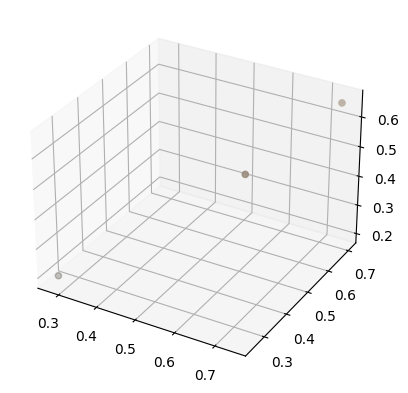

In [72]:
path = "./images/Mancs.jpg"

dataframe = pd.read_json(DATA_JSON_PATH)

inded = 0 
for i, line in enumerate(dataframe["path"]):
    if line == path:
        index = i

colors = np.array([dataframe["color"+str(i+1)][index] for i in range(N)])

x = [c[0]/255  for c in colors]
y = [c[1]/255  for c in colors]
z = [c[2]/255  for c in colors]
c = colors/255

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z,c = c)

### Orientation et Taille

In [8]:
dataframe = pd.read_json(DATA_JSON_PATH)

orientations = []
tailles = []
for taille in dataframe["résolution"]:
    # Orientation
    if taille[0] > taille[1]:
        orientations.append("paysage")
    else:
        orientations.append("portrait")
    
    nbrPixel = taille[0] * taille[1]
 
    if   nbrPixel >= 1920*1080:
        tailles.append("Grande")
    elif nbrPixel >= 1280*720:
        tailles.append("Moyenne")
    elif nbrPixel >= 720*480:
        tailles.append("Petite")
    else :
        tailles.append("Vignette")
    

dataframe["orientation"] = orientations
dataframe["taille"] = tailles

# Création du fichier JSON 
colorTable = open(DATA_JSON_PATH, "w")
colorTable.write(dataframe.to_json())
colorTable.close()


### Autres

In [ ]:
dataframe = pd.read_json(DATA_JSON_PATH)

dataframe["tags"] = [[] for i in range(len(dataframe["label"]))]

## Analyse des données

In [10]:
pd.read_json(DATA_JSON_PATH)


,label,format,link,path,résolution,model,color1,color2,color3,orientation,taille
0,Sutter Brown,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Sutter Brown.jpg,"[2736, 3648]",Canon PowerShot G12,"[86.0, 67.0, 66.0]","[218.0, 212.0, 204.0]","[166.0, 127.0, 106.0]",portrait,Grande
1,Sykes,JPG,http://commons.wikimedia.org/wiki/Special:File...,./images/Sykes.JPG,"[2592, 1944]",DSC-H50,"[177.0, 198.0, 191.0]","[23.0, 40.0, 25.0]","[109.0, 161.0, 94.0]",paysage,Grande
2,Terry,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Terry.jpg,"[966, 773]",None,"[98.0, 98.0, 98.0]","[191.0, 191.0, 190.0]","[23.0, 23.0, 22.0]",paysage,Petite
3,Tillman,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Tillman.jpg,"[1529, 2048]",None,"[137.0, 99.0, 88.0]","[96.0, 53.0, 45.0]","[196.0, 196.0, 186.0]",portrait,Grande
4,Titan,jpg,http://commons.wikimedia.org/wiki/Special:File...,./images/Titan.jpg,"[320, 250]",None,"[177.0, 177.0, 183.0]","[89.0, 76.0, 70.0]","[145.0, 140.0, 134.0]",paysage,Vignette
